In [ ]:
!pip install kaggle

In [ ]:
!kaggle datasets download -d omkargurav/face-mask-dataset

Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown
 99% 162M/163M [00:01<00:00, 140MB/s]
100% 163M/163M [00:01<00:00, 161MB/s]


In [ ]:
!unzip face-mask-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/with_mask/with_mask_3297.jpg  
  inflating: data/with_mask/with_mask_3298.jpg  
  inflating: data/with_mask/with_mask_3299.jpg  
  inflating: data/with_mask/with_mask_33.jpg  
  inflating: data/with_mask/with_mask_330.jpg  
  inflating: data/with_mask/with_mask_3300.jpg  
  inflating: data/with_mask/with_mask_3301.jpg  
  inflating: data/with_mask/with_mask_3302.jpg  
  inflating: data/with_mask/with_mask_3303.jpg  
  inflating: data/with_mask/with_mask_3304.jpg  
  inflating: data/with_mask/with_mask_3305.jpg  
  inflating: data/with_mask/with_mask_3306.jpg  
  inflating: data/with_mask/with_mask_3307.jpg  
  inflating: data/with_mask/with_mask_3308.jpg  
  inflating: data/with_mask/with_mask_3309.jpg  
  inflating: data/with_mask/with_mask_331.jpg  
  inflating: data/with_mask/with_mask_3310.jpg  
  inflating: data/with_mask/with_mask_3311.jpg  
  inflating: data/with_mask/with_mask_3312.jpg  
  inflating: data/with

In [ ]:
!pip install --upgrade tensorflow


# **Loading & Preprocessing**

In [ ]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator



# Define directories
data_dir = "data"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def preprocess_image(image):
    # Convert RGBA or grayscale images to RGB
    if image.shape[-1] == 4:
        image = image[..., :3]
    elif len(image.shape) == 2:
        image = np.stack((image,) * 3, axis=-1)

    return image.astype('float32')

# Data Augmentation & Loading
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    validation_split=0.2
)
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training'
)

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation'
)


Found 6043 images belonging to 2 classes.
Found 1510 images belonging to 2 classes.


# **BUILD MODEL  & EVALUATE**

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


# Load Pretrained Model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model layers initially

# Build Model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
out = Dense(1, activation='sigmoid', dtype='float32')(x)
model = Model(inputs=base_model.input, outputs=out)

# Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for Tuning
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train Model (Initial Training)
epochs = 10
history = model.fit(train_data, validation_data=val_data, epochs=epochs, callbacks=[lr_scheduler, early_stopping])

# Fine-tuning: Unfreeze more layers
base_model.trainable = True
for layer in base_model.layers[:-50]:  # Unfreeze last 50 layers for fine-tuning
    layer.trainable = False

# Compile again with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=0.000005), loss='binary_crossentropy', metrics=['accuracy'])

# Train Model (Fine-Tuning)
fine_tune_epochs = 10
history_fine = model.fit(train_data, validation_data=val_data, epochs=fine_tune_epochs, callbacks=[lr_scheduler, early_stopping])

# Evaluate Model
loss, acc = model.evaluate(val_data)
print(f"Validation Accuracy: {acc:.2f}")

# Save the trained model
model.save("face_mask_detector.keras")
print("Model saved successfully!")

Epoch 1/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 439s 2s/step - accuracy: 0.7961 - loss: 0.8390 - val_accuracy: 0.9550 - val_loss: 0.5381 - learning_rate: 1.0000e-04
Epoch 2/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 425s 2s/step - accuracy: 0.9476 - loss: 0.5314 - val_accuracy: 0.9510 - val_loss: 0.5059 - learning_rate: 1.0000e-04
Epoch 3/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 489s 3s/step - accuracy: 0.9573 - loss: 0.4829 - val_accuracy: 0.9649 - val_loss: 0.4579 - learning_rate: 1.0000e-04
Epoch 4/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 0.9629 - loss: 0.4392 - val_accuracy: 0.9543 - val_loss: 0.4381 - learning_rate: 1.0000e-04
Epoch 5/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 425s 2s/step - accuracy: 0.9688 - loss: 0.4019 - val_accuracy: 0.9662 - val_loss: 0.4007 - learning_rate: 1.0000e-04
Epoch 6/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 431s 2s/step - accuracy: 0.9683 - loss: 0.3831 - val_accuracy: 0.9629 - val_loss: 0.3979 - learning_rate: 1.0000e-04
Epoch 7/10
189/189 ━━━━━━━━━━━━━━━━━━━━ 485s 3s/step - acc

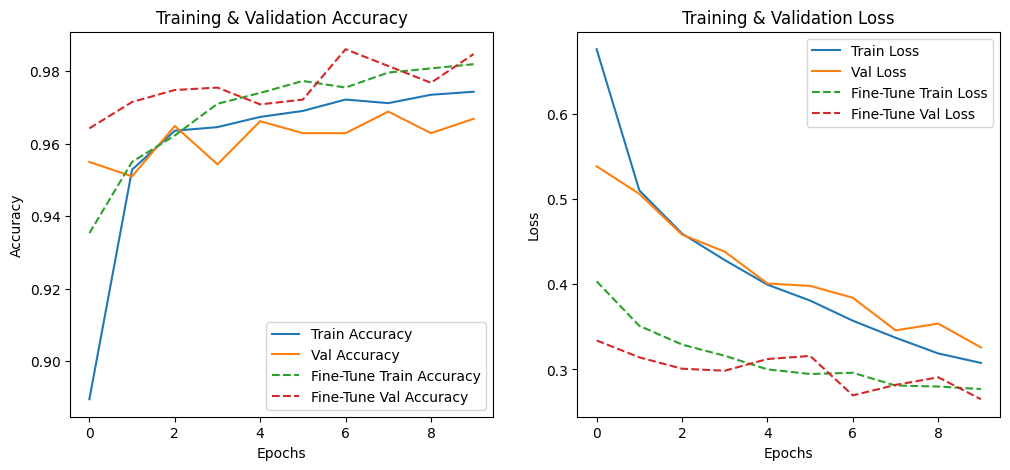

In [ ]:
import matplotlib.pyplot as plt
# Plot Training History
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-Tune Train Accuracy', linestyle='dashed')
plt.plot(history_fine.history['val_accuracy'], label='Fine-Tune Val Accuracy', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.plot(history_fine.history['loss'], label='Fine-Tune Train Loss', linestyle='dashed')
plt.plot(history_fine.history['val_loss'], label='Fine-Tune Val Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

In [ ]:
from google.colab import files

files.download("face_mask_detector.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

uploaded = files.upload()


Saving man.jpg to man.jpg


# **TEST MODEL**

In [ ]:
import cv2
from tensorflow.keras.preprocessing import image

# Function to preprocess image
def preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img = image.img_to_array(img) / 255.0  # Normalize to [0,1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Load the trained model
model = tf.keras.models.load_model("face_mask_detector.keras")

# Path to a new image
test_image_path = "man.jpg"

# Preprocess and predict
img_array = preprocess_image(test_image_path)
prediction = model.predict(img_array)

# Interpret the result
if prediction[0][0] > 0.5:
    print("No Mask Detected")
else:
    print("Mask Detected")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
No Mask Detected
